## Credit Risk Modeling EDA
**Backgroud**  
This project was completed before 2020, and the figures revised by the client.

**Challenge**  
This is a typical customer default prediction, and as any kind of the loan default analysis, we did the EDA to detect the features we want to explore.

**Solution**  
Followed the EDA procedure, we recorded and commented any question from our bank client on the business front, to have a more insight of quality of customers.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import model_selection

from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")
from IPython.display import HTML


### Load dataset

In [2]:
%%time
df = pd.read_csv('default.csv')

Wall time: 6.99 ms


In [3]:
# quick look at the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   clientid  2000 non-null   int64  
 1   income    2000 non-null   float64
 2   age       2000 non-null   float64
 3   loan      2000 non-null   float64
 4   default   2000 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 78.2 KB


### Variable types

In [4]:
target = 'default'  
num_vars = list(df.columns.drop(['clientid', 'default']))
#cat_vars = list(df.columns.drop([''])) # there's no categorical features within the dataset

## EDA (Exploratory Data Analysis)
- extract important variables;
- detect outliers and anomalies;
- test underlying assumptions;
- develop parsimonious models; 
- determine optimal factor settings

### Local EDA
The local EDA only works if your data has 'id' column or any column that individualises each database line. The main goals of the local EDA method are:
- to have a more focused view of what is happening with such an 'id' across the database (or databases)
- to have a better understanding of the DATA STORY (what the data tells us)
- to write down any questions to be asked to the Business Area

In [5]:
# choosing any id
df.tail()

,clientid,income,age,loan,default
1995,1996,59221.04487,62.3,1926.729397,0
1996,1997,69516.12757,64.3,3503.176156,0
1997,1998,44311.44926,30.9,5522.786693,1
1998,1999,43756.05660,46.8,1622.722598,0
1999,2000,69436.57955,41.5,7378.833599,0


### Overall EDA
Understanding the whole data statistical distribution pattern, the main objectives behind the Overall EDA technique are:
- to detect possible inconsistencies within the data;
- to have general comprehension of the descriptive measures and the data statistical distribution
- to have general understanding of “dirty” data(zeros, missing values, Outliers, etc.)
- to write down any questions to be asked to the Business unit

In [6]:
descriptive_measures = round(df.drop(['clientid','default'],axis=1).describe(),2)
descriptive_measures

,income,age,loan
count,2000.00,2000.00,2000.00
mean,45331.60,41.77,4444.37
std,14326.33,8.06,3045.41
min,20014.49,18.40,1.38
25%,32796.46,35.28,1939.71
50%,45789.12,41.70,3974.72
75%,57791.28,48.10,6432.41
max,69995.69,65.00,13766.05


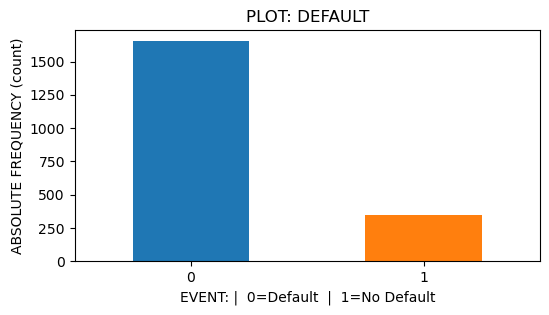

In [7]:
# data visuallization
df.default.value_counts().plot(kind = 'bar', color = ['C0', 'C1'], figsize=(6, 3), rot=0, title='PLOT: DEFAULT')
plt.xlabel("EVENT: |  0=Default  |  1=No Default")
plt.ylabel("ABSOLUTE FREQUENCY (count)");

In [8]:
# Overview of  binary variable (target)
inad = df.default.value_counts()[0]
ad = df.default.value_counts()[1]
print('Total NO DEFAULT(0):', ad, 'lines, representing',round((ad/(inad+ad))*100,2),'% of the dataset')
print('Total DEFAULT(1):', inad, 'lines, representing',round((inad/(inad+ad))*100,2),'% of the dataset')

Total NO DEFAULT(0): 347 lines, representing 17.35 % of the dataset
Total DEFAULT(1): 1653 lines, representing 82.65 % of the dataset


- The 'PLOT:DEFAULT' chart above shows that the DEFAULT event is considered a RARE EVENT, representing 17.35% of the total
- UNBALANCED data (think about some type of treatment for a model such as: Oversampling or Undersampling)

### independent variable (features)

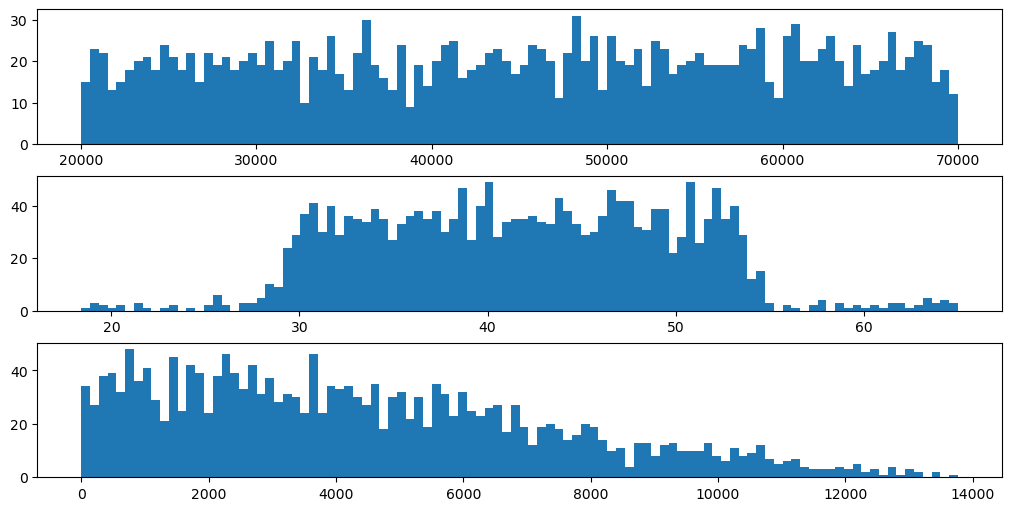

In [9]:
# code for plotting multiple HISTOGRAM
fig, axs = plt.subplots(3,1, figsize=(10, 5),constrained_layout=True)
axs[0].hist(df['income'],bins=100)
axs[1].hist(df['age'], bins=100)
axs[2].hist(df['loan'], bins=100)
plt.show();

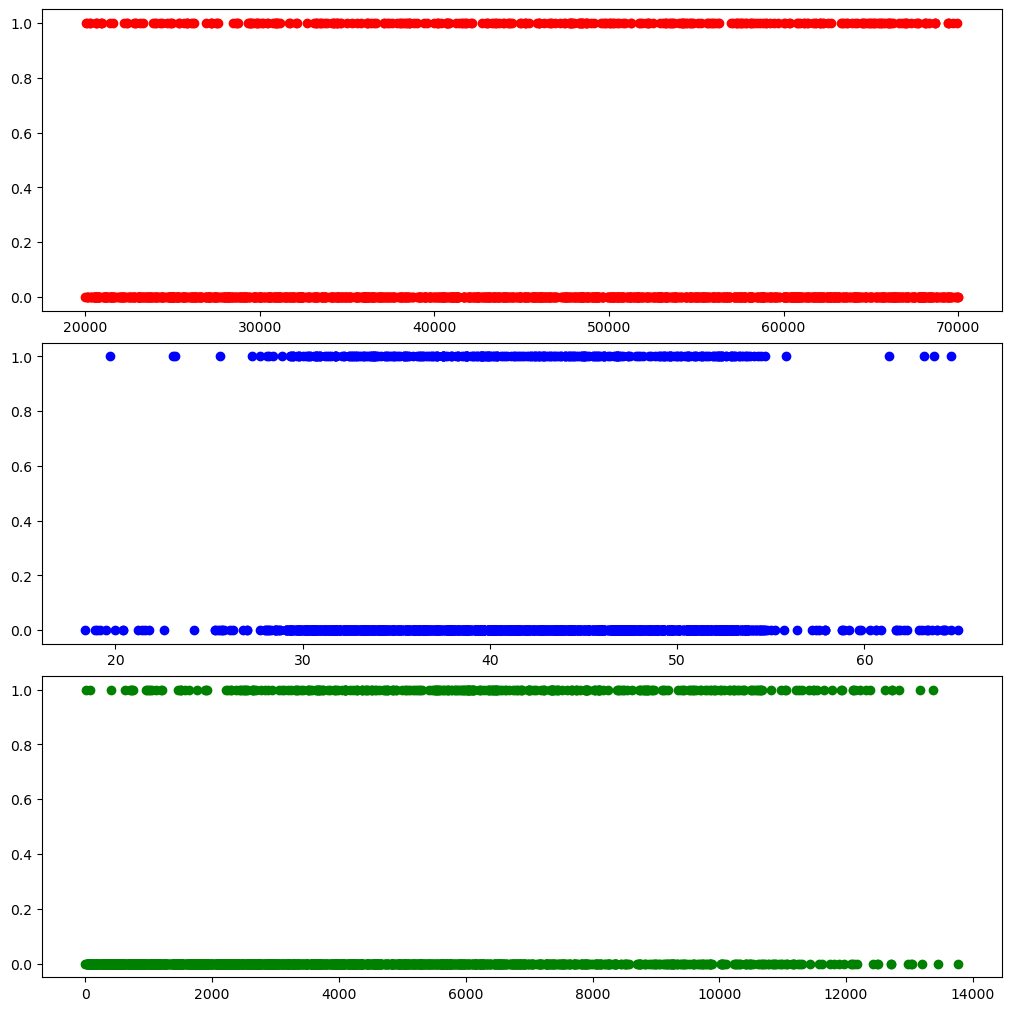

In [10]:
# code for plotting multiple SCATTER PLOTS
fig, axs = plt.subplots(3,1, figsize=(10,10),constrained_layout=True)

axs[0].scatter(x=df['income'], y=df['default'], marker='o', color='r')
axs[1].scatter(x=df['age'], y=df['default'], marker='o', color='b')
axs[2].scatter(x=df['loan'], y=df['default'], marker='o', color='g')

plt.show();

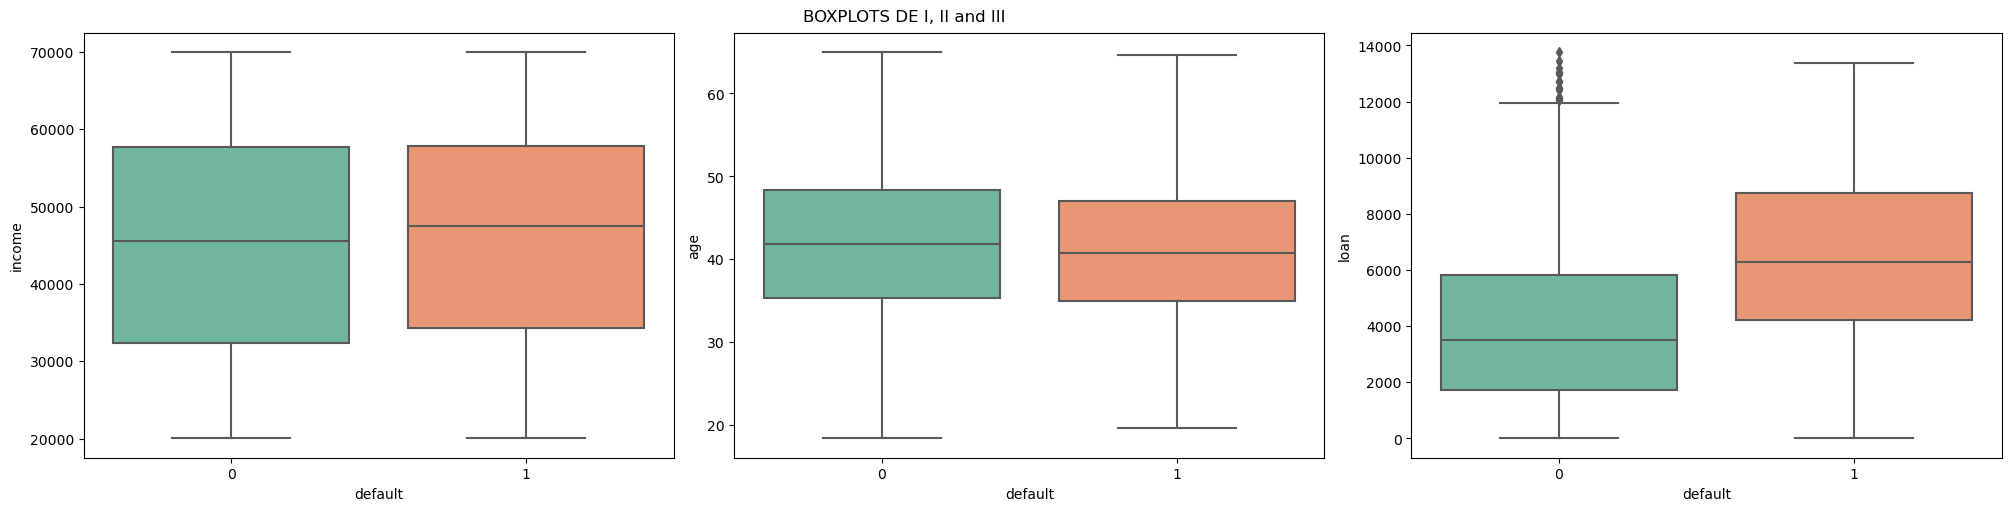

In [11]:
# code for plotting multiple BOXPLOTS
fig, axes = plt.subplots(1, 3, figsize=(20, 5),constrained_layout=True)
fig.suptitle('BOXPLOTS DE I, II and III', ha = 'right')
my_pal="Set2"

sns.boxplot(ax=axes[0], data=df, x = target, y="income", palette=my_pal)
sns.boxplot(ax=axes[1], data=df, x = target, y="age", palette=my_pal)
sns.boxplot(ax=axes[2], data=df, x = target, y="loan", palette=my_pal);

### Comments
**Income**

The feature varies between 20014 and 69995.7 thousand, with an income average ~ 45331.6. Important aspects when looking at data: 

1) quartiles (Q1, Q2 and Q3) inform us of quantity and the respective value of variation around 32796.46 to 57791.28;  
- Interpretation Q1 tells us that 25% of data has a income up to 32796.46 and 75% of data has an income above from it
- Interpretation Q2 tells us that 50% of data has a income up to 45789.12 and 75% of data has an income above from it
- Interpretation Q3 tells us that 75% of data has a income up to 57791.28 and 25% of data has an income above from it    

2) The MINIMUM value of 20014 and MAXIMUM value of 69995.7 does not indicate POSSIBLE INCONSISTENCY IN DATA once there is nothing within data that really catches my eye  

3) No missing values (0% of missing values)  

4) Tendency: according to scatter plot (above),there's no standard to define such tendency. There are ids within good or bad payer at any income available  

5) According to graphical visualization (scatter and boxplot), the feature 'INCOME' does not seem to be a candidate variable for predictor to explain the variability of y (Feature Selection), since there's no differences between the variabilities of each label, 1 and 0. Therefore, such visualizations have the sensation of lack of "movement" in both charts. The ideal situation is to TEST and get the outcomes. Perhaps if we combined with other variables, this feature becomes significant for the model

**Age**

The feature varies between -52 and 64, with an age average ~ 41 years old. Important aspects when looking at data:

1) quartiles (Q1, Q2 and Q3) tell us of quantity and the respective value of variation around 35 to 47;
- Interpretation Q1 tells us that 25% of data has an age up to 35 y.o and 75% of data has an age above from it
- Interpretation Q2 tells us that 50% of data has an age up to 41 and 75% of data has an income above from it
- Interpretation Q3 tells us that 75% of data has an age up to 49 and 25% of data has an income above from it

2) According to graphical visualization (scatter and boxplot), the feature 'AGE' does seem to be a candidate variable for predictor to explain the variability of y (Feature Selection), since there's differences between the variabilities of each label, 1 and 0. Therefore, such visualizations have the sensation of "movement" in both charts. The ideal situation is to TEST during the modeling.

**Loan**

The feature varies between 1.38 and 13766.05, with a loan average ~ 4444.37. Important aspects when looking at data:

1) quartiles (Q1, Q2 and Q3) tell us of quantity and the respective value of variation around 1939.71 to 6432.41;
- Interpretation Q1 tells us that 25% of data has a loan up to 1939.71 and 75% of data has an age above from it
- Interpretation Q2 tells us that 50% of data has a loan up to 3974.72 and 75% of data has an income above from it
- Interpretation Q3 tells us that 75% of data has a loan up to 6432.41 and 25% of data has an income above from it

2) The MINIMUM age of 1.38 and MAXIMUM age of 13766.05 does not indicate POSSIBLE INCONSISTENCY IN DATA once there is nothing within data that really catches my eye

3) No missing values (0% of missing values)

4) Tendency: according to scatter plot (above), any loan with values up to 2500 shows a trend towards good payers. On the other hand, values above 2500 do not make it possible to separate good and bad payers.

5) According to graphical visualization (scatter and boxplot), the feature 'AGE' does seem to be a candidate variable for predictor to explain the variability of y (Feature Selection), since there's differences between the variabilities of each label, 1 and 0. Therefore, such visualizations have the sensation of "movement" in both charts. The ideal situation is to TEST during the modeling.

In [12]:
# Asymmetry x Kurtosis calculation 
data_k_s = {'Asymmetry':  df[num_vars].skew(), 'Kurtosis': df[num_vars].kurtosis()}
df_k_s = pd.DataFrame (data_k_s, columns = ['Asymmetry','Kurtosis'])
df_k_s

,Asymmetry,Kurtosis
income,-0.042621,-1.201708
age,0.062857,-0.507266
loan,0.624284,-0.337330


In [13]:
# Missing Values
(df.isnull().sum()* 100 / len(df)).sort_values(ascending=False).head(10).reset_index()

,index,0
0,clientid,0.0
1,income,0.0
2,age,0.0
3,loan,0.0
4,default,0.0


In [14]:
df.dropna(inplace=True)

In [15]:
df.drop(columns="clientid",inplace=True)

features = df.columns.values[0:30]
unique_max_train = []
for feature in features:
    values = df[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])

np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,3,1,0,2
Feature,default,age,income,loan
Max duplicates,1653,17,1,1
Value,0.0,38.8,66155.9251,8106.532131


In [16]:
df['default'].value_counts()

0    1653
1     347
Name: default, dtype: int64

In [17]:
train_X = df.drop(["default"], axis=1)
train_y = np.log1p(df["default"].values)

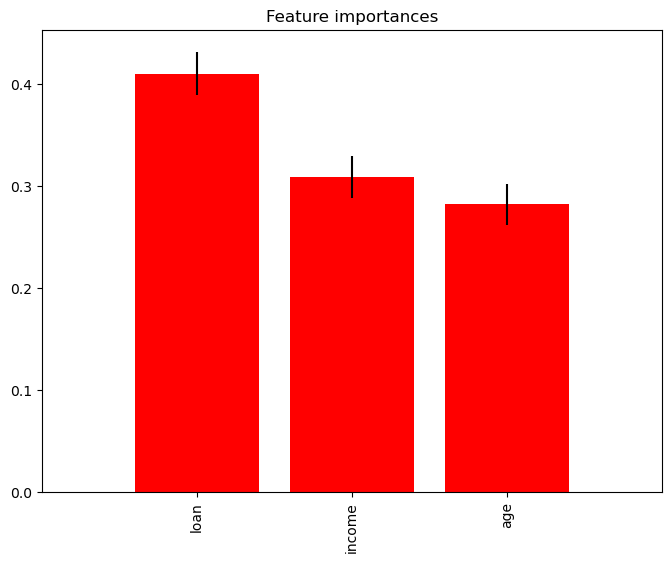

In [18]:
from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=200, max_depth=20, max_features=0.5, n_jobs=-1, random_state=0)
model.fit(train_X, train_y)

## plotando as importâncias ##
feat_names = df.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(8,6))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

In [19]:
def plot_new_feature_distribution(df1, df2, label1, label2, features, n):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,n,figsize=(18,8))

    for feature in features:
        i += 1
        plt.subplot(2,n,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=11)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show()

**Baseline**

In [20]:
def plot_roc(y_test,prob):
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title("ROC curve")
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    # show the plot
    plt.show()

In [21]:
def logistic(X,y):
    y_train=df['default'].astype('uint8')
    X_train,X_test,y_train,y_test=train_test_split(df.drop('default',axis=1),y_train,test_size=.2,random_state=2020)
    lr=LogisticRegression()
    lr.fit(X_train,y_train)
    prob=lr.predict_proba(X_test)
    
    roc=roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
    print('roc ',roc)

    return (prob[:,1],y_test)
y_train=df['default'].astype('uint8')
probs,y_test=logistic(df.drop('default',axis=1),y_train)

roc  0.7084639498432601


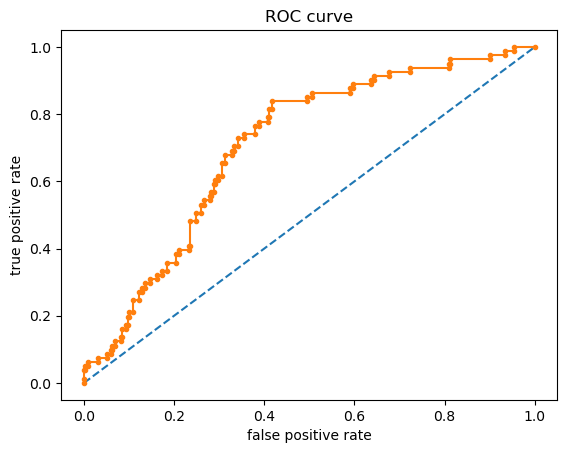

In [22]:
plot_roc(y_test,probs)

### Linear Regression

In [23]:
train_x, val_x, train_y, val_y=train_test_split(df.drop('default',axis=1),y_train,test_size=.2,random_state=2020)

clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

In [24]:
rocrl=roc_auc_score(val_y, pred_y)
rocrl

0.5245946050543753

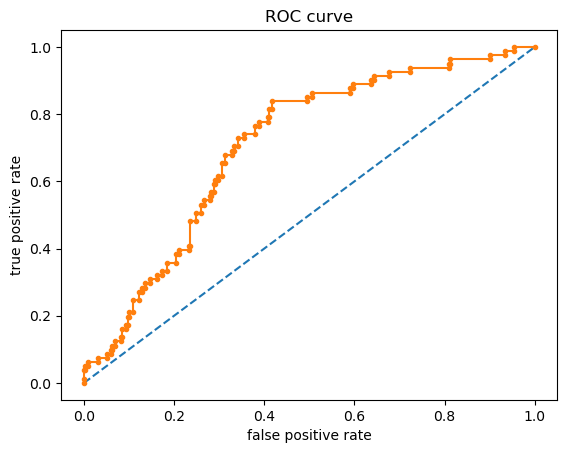

In [25]:
plot_roc(val_y, pred_y)

### Random Forest Classifier

In [26]:
%%time
model = RandomForestClassifier(n_estimators=220).fit(train_x,train_y)
predictionforest = model.predict(val_x)

Wall time: 521 ms


In [27]:
%%time
rocrf=roc_auc_score(val_y, predictionforest)
print('roc ',rocrf)

roc  0.5150934633693254
Wall time: 2 ms


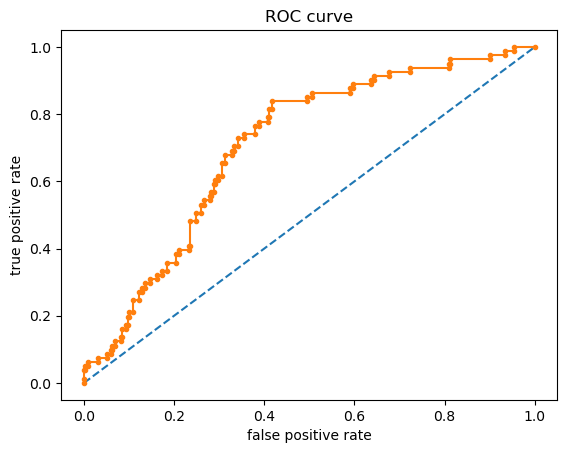

In [28]:
plot_roc(val_y, predictionforest)

In [29]:
xgb_cfl = xgb.XGBClassifier(n_jobs = -1, 
                            n_estimators = 220)

xgb_cfl.fit(train_x, train_y)
y_scorexgb = xgb_cfl.predict_proba(val_x)[:,1]

In [30]:
rocxgb=roc_auc_score(val_y, y_scorexgb)
print('roc ',rocxgb)

roc  0.6310228724021828


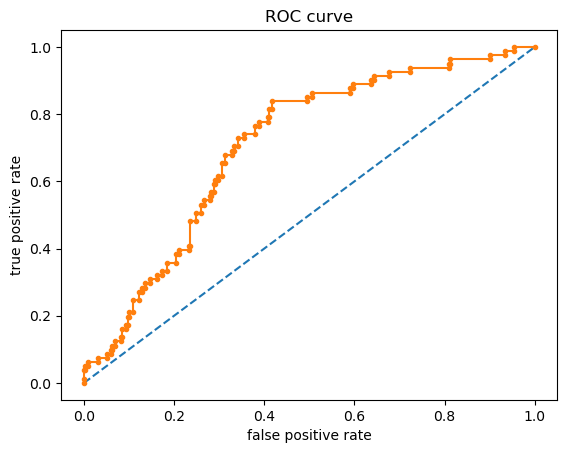

In [31]:
plot_roc(val_y, y_scorexgb)

### Grid Search CV

In [32]:
%%time
# Logistic regression 
log_cfl = LogisticRegression()

param_grid = {
            'penalty' : ['l1','l2'], 
            'class_weight' : ['balanced', None], 
            'C' : [0.1, 1, 10, 100]
            }

CV_log_cfl = GridSearchCV(estimator = log_cfl, param_grid = param_grid , scoring = 'roc_auc', verbose = 1, n_jobs = -1)
CV_log_cfl.fit(train_x, train_y)

best_parameters = CV_log_cfl.best_params_
print("The best parameters: ", best_parameters)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
The best parameters:  {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}
Wall time: 4 s


**Logistic Regression**

In [33]:
log_cfl = LogisticRegression(C = best_parameters['C'], 
                             penalty = best_parameters['penalty'], 
                             class_weight = best_parameters['class_weight'])

log_cfl.fit(train_x, train_y)
y_scoreLR = log_cfl.decision_function(val_x)

In [34]:
rocLR=roc_auc_score(val_y, y_scoreLR)
print('roc ',rocLR)

roc  0.7044003250899803


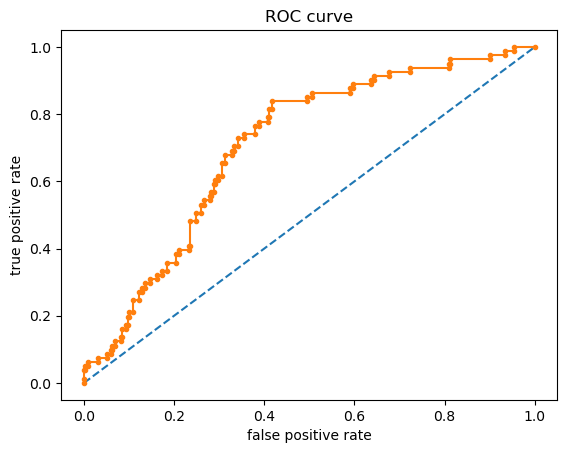

In [35]:
plot_roc(val_y, y_scoreLR)

**Random Forest Classifier**

In [36]:
rf_cfl = RandomForestClassifier(n_estimators=120).fit(train_x, train_y)

In [37]:
param_grid = {
            'n_estimators': [50, 100, 200],
            'max_features': [2, 3],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10]
            }

CV_rnd_cfl = GridSearchCV(estimator = rf_cfl, param_grid = param_grid, scoring = 'roc_auc', verbose = 10, n_jobs = -1)
CV_rnd_cfl.fit(train_x, train_y)

best_parameters = CV_rnd_cfl.best_params_
print("The best parameters: ", best_parameters)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
The best parameters:  {'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


In [38]:
rf_cfl = RandomForestClassifier(n_estimators = best_parameters['n_estimators'], 
                                 max_features = best_parameters['max_features'],  
                                 min_samples_leaf = best_parameters['min_samples_leaf'],  
                                 min_samples_split = 5)
rf_cfl.fit(train_x, train_y)
y_score = rf_cfl.predict_proba(val_x)[:,1]

In [39]:
rocRF=roc_auc_score(val_y, y_score)
print('roc ',rocRF)

roc  0.6815279229072332


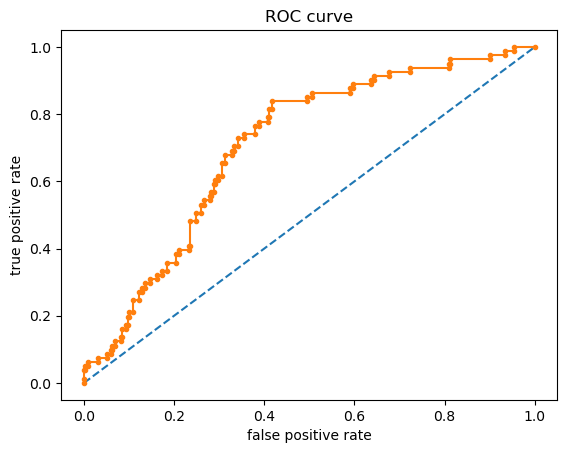

In [40]:
plot_roc(val_y, y_score)

**XGBClassifier**

In [41]:
xgb_cfl = xgb.XGBClassifier(n_jobs = -1)
xgb_cfl.fit(train_x, train_y)
y_pred = xgb_cfl.predict(val_x)
y_score = xgb_cfl.predict_proba(val_x)[:,1]

In [42]:
%%time
param_grid = {
            'n_estimators': [50, 100, 200]
              }

CV_xgb_cfl = GridSearchCV(estimator = xgb_cfl, param_grid = param_grid, scoring ='roc_auc', verbose = 2)
CV_xgb_cfl.fit(train_x, train_y)

best_parameters = CV_xgb_cfl.best_params_
print("The best parameters: ", best_parameters)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ....................................n_estimators=50; total time=   0.0s
[CV] END ....................................n_estimators=50; total time=   0.0s
[CV] END ....................................n_estimators=50; total time=   0.0s
[CV] END ....................................n_estimators=50; total time=   0.0s
[CV] END ....................................n_estimators=50; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=200; total time=   0.1s
[CV] END ...................................n_est

In [43]:
%%time
param_grid = {
            'n_estimators': [50, 100, 200]
              }

CV_xgb_cfl = GridSearchCV(estimator = xgb_cfl, param_grid = param_grid, scoring ='roc_auc', verbose = 2)
CV_xgb_cfl.fit(train_x, train_y)

best_parameters = CV_xgb_cfl.best_params_
print("The best parameters: ", best_parameters)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ....................................n_estimators=50; total time=   0.0s
[CV] END ....................................n_estimators=50; total time=   0.0s
[CV] END ....................................n_estimators=50; total time=   0.0s
[CV] END ....................................n_estimators=50; total time=   0.0s
[CV] END ....................................n_estimators=50; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=100; total time=   0.0s
[CV] END ...................................n_estimators=200; total time=   0.1s
[CV] END ...................................n_est

In [44]:
xgb_cfl2 = xgb.XGBClassifier(n_jobs = -1,n_estimators = 120)

xgb_cfl2.fit(train_x, train_y)
y_score2 = xgb_cfl.predict_proba(val_x)[:,1]

In [45]:
rocxgb=roc_auc_score(val_y, y_score2)
print('roc ',rocxgb)

roc  0.6314872866597003


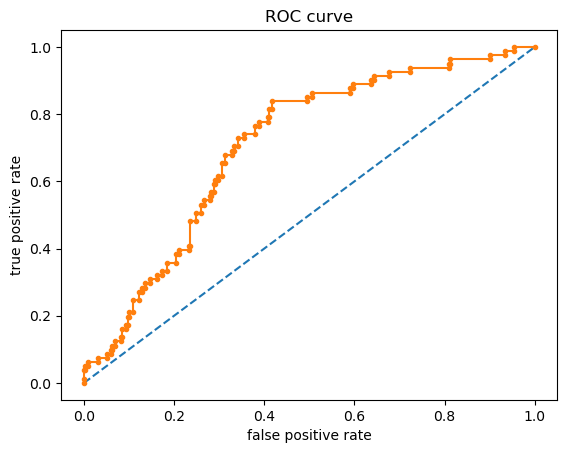

In [46]:
plot_roc(val_y, y_score2)

**Voting Classifier**

In [47]:
voting_cfl = VotingClassifier (
        estimators = [('xgb', xgb_cfl2), ('lt', log_cfl), ('rf', rf_cfl)],
                     voting='soft', weights = [0.27, 0.23, 0.5])
    
voting_cfl.fit(train_x, train_y)

y_pred = voting_cfl.predict(val_x)
y_score = voting_cfl.predict_proba(val_x)[:,1]

In [48]:
rocV=roc_auc_score(val_y, y_score)
print('roc ',rocV)

roc  0.6876040094430899


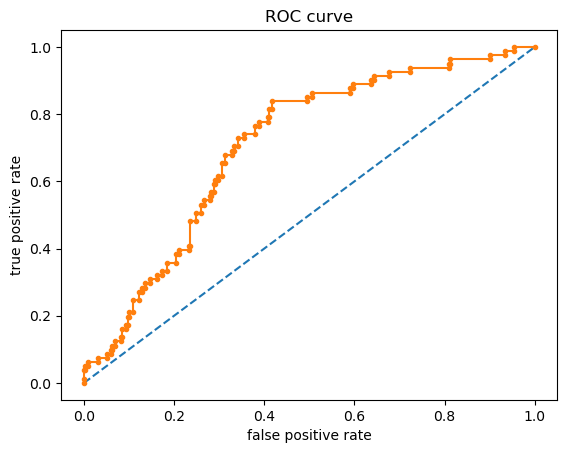

In [49]:
plot_roc(val_y, y_score)